In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import itertools
import pathlib
import re
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Load data

In [2]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv", header=None, 
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
           "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


In [3]:
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age') # label is the age, rest are features

In [4]:
# treat each feature as equal, pack to np array
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

In [5]:
# simple training
abalone_model = tf.keras.Sequential([
    layers.Dense(64),
    layers.Dense(1)
])

abalone_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam())

abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 2ms/step - loss: 62.3165
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 11.7985
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 8.4300
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 7.9515
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 7.5257
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 7.1701
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 6.9057
Epoch 8/10
104/104 [==============================] - 0s 2ms/step - loss: 6.7174
Epoch 9/10
104/104 [==============================] - 0s 2ms/step - loss: 6.5683
Epoch 10/10
104/104 [==============================] - 0s 1ms/step - loss: 6.4717


# Data preprocessing

In [6]:
# normalization layer for numeric features
normalize = preprocessing.Normalization()

# only adapt layer on the training data
normalize.adapt(abalone_features)

In [7]:
# add normalization layer to model
norm_abalone_model = tf.keras.Sequential([
    normalize,
    layers.Dense(64),
    layers.Dense(1)
])

norm_abalone_model.compile(loss=tf.losses.MeanSquaredError(), optimizer=tf.optimizers.Adam())

norm_abalone_model.fit(abalone_features, abalone_labels, epochs=10)

Epoch 1/10
104/104 [==============================] - 0s 2ms/step - loss: 92.9822
Epoch 2/10
104/104 [==============================] - 0s 2ms/step - loss: 53.8556
Epoch 3/10
104/104 [==============================] - 0s 2ms/step - loss: 16.4184
Epoch 4/10
104/104 [==============================] - 0s 2ms/step - loss: 5.7108
Epoch 5/10
104/104 [==============================] - 0s 2ms/step - loss: 5.0121
Epoch 6/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9869
Epoch 7/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9511
Epoch 8/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9621
Epoch 9/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9112
Epoch 10/10
104/104 [==============================] - 0s 2ms/step - loss: 4.9309


# Mixed data types

In [8]:
titanic = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
titanic.head()

,survived,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,1,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,1,female,35.0,1,0,53.1000,First,C,Southampton,n
4,0,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [9]:
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('survived')

In [10]:
# create a set of symbolic keras.Input for preprocessing the columns
inputs = {}

for name, column in titanic_features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'sex': <tf.Tensor 'sex:0' shape=(None, 1) dtype=string>,
 'age': <tf.Tensor 'age:0' shape=(None, 1) dtype=float32>,
 'n_siblings_spouses': <tf.Tensor 'n_siblings_spouses:0' shape=(None, 1) dtype=float32>,
 'parch': <tf.Tensor 'parch:0' shape=(None, 1) dtype=float32>,
 'fare': <tf.Tensor 'fare:0' shape=(None, 1) dtype=float32>,
 'class': <tf.Tensor 'class:0' shape=(None, 1) dtype=string>,
 'deck': <tf.Tensor 'deck:0' shape=(None, 1) dtype=string>,
 'embark_town': <tf.Tensor 'embark_town:0' shape=(None, 1) dtype=string>,
 'alone': <tf.Tensor 'alone:0' shape=(None, 1) dtype=string>}

In [11]:
# concat numeric inputs, and run normalization

numeric_inputs = {name:input for name, input in inputs.items() if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))

# normalization
norm = preprocessing.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<tf.Tensor 'normalization_1/truediv:0' shape=(None, 4) dtype=float32>

In [12]:
# collect all symbolic preprocessing results to be concatenated later with string preprocessing
preprocessed_inputs = [all_numeric_inputs]

In [13]:
# need to one hot encode the string features

for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue

    # map string features to integer indices in a vocab
    lookup = preprocessing.StringLookup(vocabulary=np.unique(titanic_features[name]))

    # one hot encode the feature
    one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

In [14]:
# create a model that preprocess inputs
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)
titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

# plot the model
tf.keras.utils.plot_model(model=titanic_preprocessing, rankdir='LR', dpi=72, show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [15]:
# convert raw feature Dataframe into a dictionary of tensors
titanic_features_dict = {name: np.array(value) for name, value in titanic_features.items()}

In [16]:
# check the preprocessing on one sample
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 33), dtype=float32, numpy=
array([[-0.61 ,  0.395, -0.479, -0.497,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  1.   ,
         0.   ]], dtype=float32)>

In [17]:
# build the model
def titanic_model(preprocessing_head, inputs):
    body = tf.keras.Sequential([
        layers.Dense(64),
        layers.Dense(1)
    ])

    # preprocessing
    preprocessed_inputs = preprocessing_head(inputs)

    result = body(preprocessed_inputs)
    
    model = tf.keras.Model(inputs, result)
    model.compile(loss=tf.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.optimizers.Adam())

    return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

In [18]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, epochs=10)

Epoch 1/10
20/20 [==============================] - 0s 3ms/step - loss: 0.6130
Epoch 2/10
20/20 [==============================] - 0s 3ms/step - loss: 0.5395
Epoch 3/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4965
Epoch 4/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4685
Epoch 5/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4506
Epoch 6/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4398
Epoch 7/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4320
Epoch 8/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4278
Epoch 9/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4241
Epoch 10/10
20/20 [==============================] - 0s 3ms/step - loss: 0.4216


In [19]:
# preprocessing is part of model, so can save and reload
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

# check reloaded on one sample
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after) < 1e-3
print(before)
print(after)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: test\assets
tf.Tensor([[-1.944]], shape=(1, 1), dtype=float32)
tf.Tensor([[-1.944]], shape=(1, 1), dtype=float32)


# tf.data

### in memory data

In [20]:
# function to slice features from a dict
def slices(features):
    for i in itertools.count():
        # for each feature take index i
        example = {name: values[i] for name, values in features.items()}
        yield example

# test the function
for example in slices(titanic_features_dict):
    for name, value in example.items():
        print(f"{name:19s}:{value}")
    break

sex                :male
age                :22.0
n_siblings_spouses :1
parch              :0
fare               :7.25
class              :Third
deck               :unknown
embark_town        :Southampton
alone              :n


In [21]:
# the same can be done using tf.data

# this will create a dataset by slicing each item of the dictionary as a sample
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

for example in features_ds:
    for name, value in example.items():
        print(f"{name:19s}:{value}")
    break

sex                :b'male'
age                :22.0
n_siblings_spouses :1
parch              :0
fare               :7.25
class              :b'Third'
deck               :b'unknown'
embark_town        :b'Southampton'
alone              :b'n'


In [22]:
# can also slice a tuple
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

In [23]:
# shuffle and batch the dataset
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

# train using dataset
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4204
Epoch 2/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4200
Epoch 3/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4198
Epoch 4/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4197
Epoch 5/5
20/20 [==============================] - 0s 4ms/step - loss: 0.4183


### from one file

In [24]:
titanic_file_path = tf.keras.utils.get_file("train.csv", "https://storage.googleapis.com/tf-datasets/titanic/train.csv")

In [25]:
# tf.data can also read csv file in dataset
# it will automatically use column headers as features, and determine type of each column
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    titanic_file_path,
    batch_size=5, # for example just use 5
    label_name='survived',
    num_epochs=1,
    ignore_errors=True
)

# check the loaded dataset
for batch, label in titanic_csv_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value}")
    print()
    print(f"{'label':20s}: {label}")

sex                 : [b'male' b'male' b'male' b'male' b'female']
age                 : [25. 43. 57.  9. 24.]
n_siblings_spouses  : [1 1 0 4 0]
parch               : [0 1 0 2 0]
fare                : [91.079 26.25  12.35  31.388 83.158]
class               : [b'First' b'Second' b'Second' b'Third' b'First']
deck                : [b'B' b'unknown' b'unknown' b'unknown' b'C']
embark_town         : [b'Cherbourg' b'Southampton' b'Queenstown' b'Southampton' b'Cherbourg']
alone               : [b'n' b'n' b'y' b'n' b'y']

label               : [1 0 0 0 1]


In [26]:
# tf.data can also decompress data
traffic_volume_csv_gz = tf.keras.utils.get_file(
    'Metro_Interstate_Traffic_Volume.csv.gz', 
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz",
    cache_dir='.', cache_subdir='traffic')

traffic_volume_csv_gz_ds = tf.data.experimental.make_csv_dataset(
    traffic_volume_csv_gz,
    batch_size=256,
    label_name='traffic_volume',
    num_epochs=1,
    compression_type='GZIP'
)

for batch, label in traffic_volume_csv_gz_ds.take(1):
    for key, value in batch.items():
        print(f"{key:20s}: {value[:5]}")
    print()
    print(f"{'label':20s}: {label[:5]}")

holiday             : [b'None' b'None' b'None' b'None' b'None']
temp                : [265.33 280.38 296.1  271.14 272.4 ]
rain_1h             : [0.   0.   0.25 0.   0.  ]
snow_1h             : [0. 0. 0. 0. 0.]
clouds_all          : [90 40  8 90 90]
weather_main        : [b'Snow' b'Clouds' b'Rain' b'Haze' b'Mist']
weather_description : [b'heavy snow' b'scattered clouds' b'light rain' b'haze' b'mist']
date_time           : [b'2013-01-03 15:00:00' b'2013-05-06 11:00:00' b'2013-06-16 18:00:00'
 b'2013-02-10 11:00:00' b'2013-03-16 19:00:00']

label               : [5297 4507 3472 2177 3572]


### multiple files

In [27]:
fontz_zip = tf.keras.utils.get_file(
    'fonts.zip',  "https://archive.ics.uci.edu/ml/machine-learning-databases/00417/fonts.zip",
    cache_dir='.', cache_subdir='fonts',
    extract=True)

In [28]:
# this dataset contains multiple csv files
font_csvs = sorted(str(p) for p in pathlib.Path('fonts').glob("*.csv"))
font_csvs[:10]

['fonts\\AGENCY.csv',
 'fonts\\ARIAL.csv',
 'fonts\\BAITI.csv',
 'fonts\\BANKGOTHIC.csv',
 'fonts\\BASKERVILLE.csv',
 'fonts\\BAUHAUS.csv',
 'fonts\\BELL.csv',
 'fonts\\BERLIN.csv',
 'fonts\\BERNARD.csv',
 'fonts\\BITSTREAMVERA.csv']

In [29]:
len(font_csvs)

153

In [30]:
# read all csv into one dataset, order of files is shuffled in each iteration
fonts_ds = tf.data.experimental.make_csv_dataset(
    file_pattern = "fonts/*.csv", # read all csv
    batch_size=10,
    num_epochs=1,
    num_parallel_reads=20, # read 20 files in parallel
    shuffle_buffer_size=10000
)

In [31]:
for features in fonts_ds.take(1):
    for i, (name, value) in enumerate(features.items()):
        if i>15:
            break
        print(f"{name:20s}: {value}")
print('...')
print(f"[total: {len(features)} features]")

font                : [b'PLAYBILL' b'MODERN' b'MODERN' b'CITYBLUEPRINT' b'SWIS721' b'SCRIPTB'
 b'PERPETUA' b'TAHOMA' b'COPPERPLATE' b'ROCKWELL']
fontVariant         : [b'PLAYBILL' b'MODERN NO. 20' b'MODERN NO. 20' b'CITYBLUEPRINT'
 b'SWIS721 LTEX BT' b'SCRIPT MT BOLD' b'PERPETUA TITLING MT' b'TAHOMA'
 b'COPPERPLATE GOTHIC LIGHT' b'ROCKWELL EXTRA BOLD']
m_label             : [  210   176   173   235   223   231   219 65155   120    46]
strength            : [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
italic              : [1 0 0 0 0 0 1 0 1 0]
orientation         : [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
m_top               : [20 20 59 48 36 56 21 21 41 71]
m_left              : [25 21 21 21 26 20 31 23 20 25]
originalH           : [55 10  4 43 49 43 64 66 37 12]
originalW           : [26 10 14 25 33 25 56 11 47 16]
h                   : [20 20 20 20 20 20 20 20 20 20]
w                   : [20 20 20 20 20 20 20 20 20 20]
r0c0                : [  1   1 255   1   1   1   1   1   1 255]
r0c1       

In [32]:
# the csv file has an image flattened as a row
# pack each row's pixels into one image tensor

def make_images(features):
    image = [None] * 400 # image is 400 pixel
    new_feats = {}

    for name, value in features.items():
        match = re.match('r(\d+)c(\d+)', name)  # only get the pixel columns
        if match:
            image[int(match.group(1)) * 20 + int(match.group(2))] = value
        else:
            new_feats[name] = value
        
    image = tf.stack(image, axis=0)
    image = tf.reshape(image, [20, 20, -1])
    new_feats['image'] = image

    return new_feats

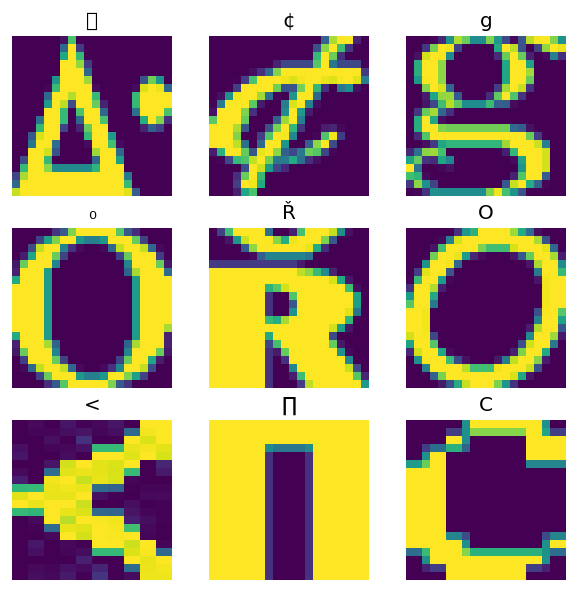

In [33]:
# convert row pixels to images
fonts_image_ds = fonts_ds.map(make_images)

for features in fonts_image_ds.take(1):
    break

plt.figure(figsize=(6, 6), dpi=120)
for n in range(9):
    plt.subplot(3, 3, n+1)
    plt.imshow(features['image'][..., n])
    plt.title(chr(features['m_label'][n]))
    plt.axis('off')